# STEP 2 - COMBINE ALL RISK FACTORS AND NEIGHBOURHOODS

##### Created by - Sanjana Tule 
##### Date - 14/08/2021


This code integrates the risk factors and the neighbourhoods for downstream path finding algorithm

1.   Choose pickles files to combine the risk factors into 1 graph for each neighbourhood
2.   Combine the neighbourhoods and normalise the risk score
3.   Add nodes for parks and evacuation sites


Different Risk Factors:

1. Distance Risk - raw values , higher values means high risk and lower value means low risk
2. Speed Risk - speed is either 6,7,8,9. Higher the value means higher risk as speed is low in that zone.
3. Density Risk - raw values, higher density means lots of buildings and higher risk
4. Liquification Risk - values either 0/1. 0 means no liquification and hence safe area. 1 means not so safe.
4. Width Risk - values between 0 and 5. 5 means less width and hence more risk. 0 means high width and less risk.



In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [3]:
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STEP 1 - COMBINE ALL RISK FACTORS - 
DISTANCE RISK, 
MAX SPEED LIMIT RISK, 
BUILDING DENSITY RISK 
FOR EACH OF THE 3 NEIGHBOURHOODS - NORTHRIDGE, NORTH HILLS AND CHATSWORTH

In [63]:
# STEP 1 - COMBINE RISK FACTORS FOR ALL NEIGHBOURHOODS

print("1. COMBINING RISK FACTORS FOR EACH NEIGHBOURHOOD")
# Define lookup dict for neighbourhood address
neighbourhood_lookup = {
    "northridge": "northridge, California, USA",
    "chatsworth": "chatsworth, California, USA",
    "northhills": "north hills, California, USA"
}

# --- NORTHRIDGE, CHATSWORTH AND NORTH HILLS --- #
for n in ['northridge','chatsworth','northhills']:
  print("Processing neighbourhood:", n)

  distance_risk_score_file_name = '/content/drive/My Drive/omdena/earthquake/1_1_' +  str(n) + '_graph_distance_risk_added.pickle'
  density_risk_score_file_name  = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_building_density_risk_addded.pickle'
  speed_risk_score_file_name    = '/content/drive/My Drive/omdena/earthquake/1_3_' +  str(n) + '_graph_speed_risk_added.pickle'
  width_risk_score_file_name    = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_width_added.pickle'
  liq_risk_score_file_name      = '/content/drive/My Drive/omdena/earthquake/1_2_' +  str(n) + '_graph_liq_addded.pickle'
  combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_' +  str(n) + '_graph_all_risk_added.pickle'

  # LOAD MASTER GRAPH
  G_all_neighbourhood   = ox.graph_from_place(neighbourhood_lookup[n])
  nodes_master,edges_master = ox.graph_to_gdfs(G_all_neighbourhood)
  
  # count of edges and nodes in master graph
  display('Master graph has edges {} and nodes {}'.format(edges_master.shape[0],nodes_master.shape[0]))
  
  # RISK FACTOR 1. distance pickle
  graph_distance = nx.read_gpickle(distance_risk_score_file_name)
  _,edges_distance = ox.graph_to_gdfs(graph_distance)

  # RISK FACTOR 2. building density pickle
  density_pickle = nx.read_gpickle(density_risk_score_file_name)
  _,edges_bd = ox.graph_to_gdfs(density_pickle)
  
  # RISK FACTOR 3. speed limit pickle
  speed_pickle = nx.read_gpickle(speed_risk_score_file_name)
  _,edges_sp = ox.graph_to_gdfs(speed_pickle)  

  # RISK FACTOR 4. road width pickle
  road_width_pickle = nx.read_gpickle(width_risk_score_file_name)
  _,edges_w = ox.graph_to_gdfs(road_width_pickle)

  # RISK FACTOR 5. liquification pickle
  liq_pickle = nx.read_gpickle(liq_risk_score_file_name)
  _,edges_l = ox.graph_to_gdfs(liq_pickle)


  # rename columns and only extract needed columns  
  edges_l = edges_l.rename(columns={"liq_zone": "liq_risk_score"})
  edges_bd = edges_bd.rename(columns={"Building": "density_risk_score"})

  edges_distance['distance_risk_score'] = edges_distance['max']
  edges_distance = pd.DataFrame(edges_distance['distance_risk_score'])
  edges_l = pd.DataFrame(edges_l['liq_risk_score'])
  edges_bd = pd.DataFrame(edges_bd['density_risk_score'])
  edges_w = pd.DataFrame(edges_w['width_risk_score'])
  edges_sp = pd.DataFrame(edges_sp['max_speed_risk_score'])

  # join edges dataframe on index
  combine_1 = edges_master.join(edges_distance,lsuffix='_org', rsuffix='_other')
  combine_2 = combine_1.join(edges_sp,lsuffix='_org', rsuffix='_other')
  combine_3 = combine_2.join(edges_bd,lsuffix='_org', rsuffix='_other')
  combine_4 = combine_3.join(edges_w,lsuffix='_org', rsuffix='_other')
  combined_risk_edges = combine_4.join(edges_l,lsuffix='_org', rsuffix='_other')

  #display(combined_risk_edges.head())

  # Create a new graph and save in pickle file
  combined_risk_graph = ox.graph_from_gdfs(nodes_master, combined_risk_edges)
  nodes_combined,edges_combined = ox.graph_to_gdfs(combined_risk_graph)
  #display('Combined graph has edges {} and nodes {}'.format(edges_combined.shape[0],nodes_combined.shape[0]))

  # Reconcile the graph
  if (edges_combined.shape[0] != edges_master.shape[0]) or (nodes_combined.shape[0] != nodes_master.shape[0]):
    print("Combined Graph for {} is missing some nodes and edges".format(n))
    break

  # write to disk
  nx.write_gpickle(combined_risk_graph, combined_risk_file_name)

1. COMBINING RISK FACTORS FOR EACH NEIGHBOURHOOD
Processing neighbourhood: northridge


'Master graph has edges 22335 and nodes 7663'

Processing neighbourhood: chatsworth


'Master graph has edges 17254 and nodes 5925'

Processing neighbourhood: northhills


'Master graph has edges 8686 and nodes 3213'

STEP 2 - COMBINE ALL THE 3 NEIGHBOURHOODS - NORTHRIDGE, NORTH HILLS AND CHATSWORTH

2. COMBINING NEIGHBOURHOOD


'Master graph has edges 48456 and nodes 16810'

Combining : chatsworth
Combining : northhills


'Combined graph has edges 48460 and nodes 16810'

osmid  ... liq_risk_score
u        v          key                          ...               
21569692 4682380491 0    [185913115, 401489878]  ...            1.0
         6784129512 0                 401489883  ...            1.0
         6784129514 0                 401489877  ...            1.0
29409715 6403348096 0                  15240187  ...            1.0
         6403348099 0                 400864506  ...            1.0

[5 rows x 19 columns]

osmid  ... liq_risk_score
u        v          key                          ...               
21569692 4682380491 0    [185913115, 401489878]  ...            1.0
         6784129512 0                 401489883  ...            1.0
         6784129514 0                 401489877  ...            1.0
29409715 6403348096 0                  15240187  ...            1.0
         6403348099 0                 400864506  ...            1.0

[5 rows x 19 columns]

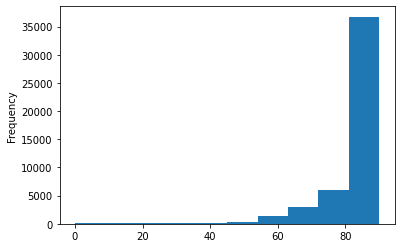

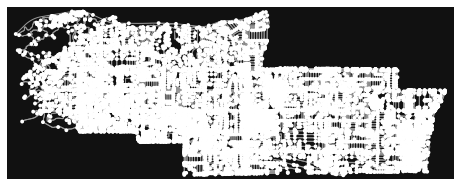

In [64]:
# STEP 2 - COMBINE NEIGHBOURHOODS


print("2. COMBINING NEIGHBOURHOOD")
# fetch master nodes and edges
places = ['northridge, California, USA','chatsworth, California, USA','north hills, California, USA']
G_all_neighbourhoods   = ox.graph_from_place(places)
nodes_master,edges_master = ox.graph_to_gdfs(G_all_neighbourhoods)

# count of edges and nodes
display('Master graph has edges {} and nodes {}'.format(edges_master.shape[0],nodes_master.shape[0]))

# combine edges for all neighbourhoods
combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_northridge_graph_all_risk_added.pickle'
graph_distance = nx.read_gpickle(combined_risk_file_name)
_,edges_all= ox.graph_to_gdfs(graph_distance)

for n in ['chatsworth','northhills']:
  print("Combining :",n)
  combined_risk_file_name       = '/content/drive/My Drive/omdena/earthquake/1_' +  str(n) + '_graph_all_risk_added.pickle'
  graph_distance = nx.read_gpickle(combined_risk_file_name)
  _,edges_app= ox.graph_to_gdfs(graph_distance)
  edges_all = edges_all.append(edges_app) 

# join it with master edges
edges_all = edges_all[['distance_risk_score','max_speed_risk_score','density_risk_score','width_risk_score','liq_risk_score']]
edges_master = edges_master.join(edges_all,lsuffix='_org', rsuffix='_other')
 
display('Combined graph has edges {} and nodes {}'.format(edges_master.shape[0],nodes_master.shape[0]))
display(edges_master.head())

##### NORMALISE RISK FACTORS ######

# normalise speed columns
edges_master['max_speed_risk_score'] = (edges_master['max_speed_risk_score'] - edges_master['max_speed_risk_score'].min()) / (edges_master['max_speed_risk_score'].max() - edges_master['max_speed_risk_score'].min())
# reverse the distance risk score
edges_master['distance_risk_score'] = edges_master['distance_risk_score'].apply(lambda x: abs(x - edges_all['distance_risk_score'].max()))
edges_master['distance_risk_score'].plot.hist()

# normalise distance columns
edges_master['distance_risk_score'] = (edges_master['distance_risk_score'] - edges_master['distance_risk_score'].min()) / (edges_master['distance_risk_score'].max() - edges_master['distance_risk_score'].min())
# normalise density columns
edges_master['density_risk_score'] = (edges_master['density_risk_score'] - edges_master['density_risk_score'].min()) / (edges_master['density_risk_score'].max() - edges_master['density_risk_score'].min())
# normalise width columns
edges_master['width_risk_score'] = (edges_master['width_risk_score'] - edges_master['width_risk_score'].min()) / (edges_master['width_risk_score'].max() - edges_master['width_risk_score'].min())

display(edges_master.head())

# create a graph from all nodes and edges
graph_all = ox.graph_from_gdfs(nodes_master,edges_master)

# visualise graph
fig, ax = ox.plot_graph(graph_all)

STEP 3 - ADD NEAREST NODES FOR PARKS FOR EVACUATION SITES


In [65]:
# STEP 3 - ADD PARK NODES FOR DOWNSTREAM APP

warnings.filterwarnings("ignore")
geolocator = Nominatim(user_agent="Nominatim")
nodes_master['evacuation_flag'] = 'N'
nodes_master['evacuation_name'] = 'NA'

# get all parks in 3 neighbourhoods
for n in ['northridge','chatsworth','north hills']:
  print("Processing parks in neighbourhood:", n)
  place = str(n) + ", California, USA"
  parks = ox.geometries_from_place(place, {"leisure":"park"})

  for osmnid,park_details in parks.iterrows():
    if not pd.isnull(park_details['name']):
      
      # find the park lat/lon
      park_address = park_details['name'] + ', ' + str(n) + ", California, USA"

      park_latlon = geolocator.geocode(park_address)
      park_point = (park_latlon.latitude, park_latlon.longitude)
      
      # find the nearest node
      source_node = ox.get_nearest_node(graph_all,park_point,return_dist=False)
      
      # add evacuation site on that node.
      nodes_master.loc[(source_node),'evacuation_name'] = park_details['name']
      nodes_master.loc[(source_node),'evacuation_flag'] = 'Y'
      nodes_master.loc[(source_node),'evacuation_type'] = 'park'


Processing parks in neighbourhood: northridge


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

Processing parks in neighbourhood: chatsworth


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

Processing parks in neighbourhood: north hills


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [66]:
display("View Evacuation Nodes",nodes_master[nodes_master['evacuation_flag'] == 'Y'])

'View Evacuation Nodes'

,y,x,highway,street_count,ref,geometry,evacuation_flag,evacuation_name,evacuation_type
osmid,,,,,,,,,
123198975,34.239073,-118.630699,NaN,3,NaN,POINT (-118.63070 34.23907),Y,Chatsworth Oaks Park,park
367962589,34.238741,-118.508881,NaN,3,NaN,POINT (-118.50888 34.23874),Y,Dearborn Park,park
4036602793,34.269342,-118.555279,NaN,3,NaN,POINT (-118.55528 34.26934),Y,Limekiln Canyon Park,park
4299571956,34.275574,-118.592367,NaN,1,NaN,POINT (-118.59237 34.27557),Y,Browns Creek Park,park
4489631571,34.229686,-118.466107,NaN,3,NaN,POINT (-118.46611 34.22969),Y,North Hills Community Park,park
4569962917,34.239471,-118.529319,NaN,3,NaN,POINT (-118.52932 34.23947),Y,Oviatt Lawn,park
4592745428,34.247348,-118.629805,NaN,1,NaN,POINT (-118.62980 34.24735),Y,Andora Open Space,park
4636164573,34.253069,-118.533800,NaN,3,NaN,POINT (-118.53380 34.25307),Y,Northridge Park,park
6027909235,34.233205,-118.547530,NaN,1,NaN,POINT (-118.54753 34.23321),Y,Vanalden Park,park


STEP 4 - ADD NEAREST NODES FOR SHELTERS FOR EVACUATION SITES

In [67]:
# STEP 4 - ADD SHELTER NODES FOR DOWNSTREAM APP
warnings.filterwarnings("ignore")
shelterFacilities = geopandas.read_file('/content/drive/My Drive/omdena/earthquake/shelters.geojson.txt')
shelterFacilities.crs = 'epsg:4326'
#display(shelterFacilities['CITY'].unique())

shelterFacilities = shelterFacilities[shelterFacilities['CITY'].isin(['NORTH HILLS','NORTHRIDGE','CHATSWORTH'])]
#display(shelterFacilities.head())

for ind, address in shelterFacilities[['SHELTER_NAME','LATITUDE','LONGITUDE']].iterrows():
  shelter_lat = address['LATITUDE']
  shelter_long = address['LONGITUDE']

  # find the nearest node
  source_node = ox.get_nearest_node(graph_all,(shelter_lat,shelter_long),return_dist=False)
  #print("source node found.source node:",source_node)
      
  # add evacuation site on that node.
  nodes_master.loc[(source_node),'evacuation_name'] = address['SHELTER_NAME']
  nodes_master.loc[(source_node),'evacuation_flag'] = 'Y'
  nodes_master.loc[(source_node),'evacuation_type'] = 'shelter'

In [38]:
# See all evacuation sites
display("View Evacuation Nodes",nodes_master[nodes_master['evacuation_flag'] == 'Y'])

'View Evacuation Nodes'

,y,x,highway,street_count,ref,geometry,evacuation_flag,evacuation_name,evacuation_type
osmid,,,,,,,,,
122598528,34.239477,-118.515618,NaN,4,NaN,POINT (-118.51562 34.23948),Y,Northridge Academy High School Multipurpose Ro...,shelter
122610180,34.260862,-118.579834,NaN,4,NaN,POINT (-118.57983 34.26086),Y,Mason Park Recreation Center,shelter
122720277,34.244964,-118.523305,NaN,3,NaN,POINT (-118.52330 34.24496),Y,Northridge Academy High School Gym 1/2,shelter
122755787,34.224625,-118.524582,NaN,3,NaN,POINT (-118.52458 34.22462),Y,Northridge Middle School (Gym) 1 of 2,shelter
122849458,34.253620,-118.592949,stop,3,NaN,POINT (-118.59295 34.25362),Y,Lawrence Middle School Gym 1/2,shelter
123132907,34.238337,-118.480672,NaN,3,NaN,POINT (-118.48067 34.23834),Y,Heritage Christian School South Campus Gym,shelter
123145506,34.251814,-118.584202,stop,4,NaN,POINT (-118.58420 34.25181),Y,"Chatsworth High School, LG/SM Gyms 1/2",shelter
123198975,34.239073,-118.630699,NaN,3,NaN,POINT (-118.63070 34.23907),Y,Chatsworth Oaks Park,park
331380117,34.273145,-118.565802,NaN,3,NaN,POINT (-118.56580 34.27315),Y,North Valley YMCA,shelter


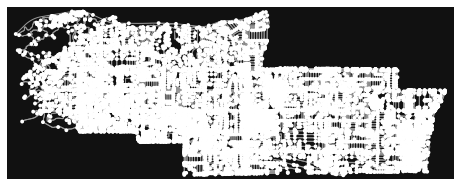

In [68]:
# STEP 5 - save graph in pickle files
all_neighbourhood = '/content/drive/My Drive/omdena/earthquake/1_all_graph_all_risk_added.pickle'
all_neighbourhood_gdf = '/content/drive/My Drive/omdena/earthquake/1_all_graph_gdf.pickle'


# create a graph from all nodes and edges
graph_all = ox.graph_from_gdfs(nodes_master,edges_master)
# visualise graph
fig, ax = ox.plot_graph(graph_all)

# create a new graph and save in pickle file
nx.write_gpickle(graph_all, all_neighbourhood)

# save gdf of the places
place = ['Northridge, California, USA','Chatsworth, California, USA','North Hills, California, USA']
combined_gdf = ox.geocode_to_gdf(place)
nx.write_gpickle(combined_gdf,all_neighbourhood_gdf)